In [1]:
import os
os.chdir('../..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas
import re

from utils.util_pandas import PandasDF, create_agent_from_row

np.random.seed(7)
torch.manual_seed(7)

In [3]:
# Load run results
HOME_DIR = './data'
PANDAS_DATAFRAME_FILENAME = HOME_DIR + '/df.xls'
RESULTS_DIR = HOME_DIR + '/results'
RESULTS_KEY = 'results_filename'
MODELS_DIR = HOME_DIR + '/saved_models'
MODELS_KEY = 'model_filename'

DF = PandasDF(HOME_DIR=HOME_DIR, RESULTS_DIR=RESULTS_DIR, MODELS_DIR=MODELS_DIR,
              PANDAS_DATAFRAME_FILENAME=PANDAS_DATAFRAME_FILENAME,
              RESULTS_KEY=RESULTS_KEY, MODELS_KEY=MODELS_KEY)

In [4]:
DF.df.keys()

Index(['reduce_std_by', 'reduce_std_every', 'epochs', 'learner',
       'inner_batch_size', 'std_explore', 'restrict_energy', 'inner_steps',
       'stepsize_meta', 'SNR_db', 'bits_per_symbol', 'optimizer',
       'first_order', 'seed', 'model', 'hidden_layers', 'nshots', 'meta-alg',
       'stepsize_inner', 'outer_batch_size', 'ntasks', 'loss_function',
       'model_filename', 'results_filename'],
      dtype='object')

In [5]:
print("Inner steps", DF.df['inner_steps'].unique())
print("Length", len(DF.df))

Inner steps ['None' 5 10]
Length 72


In [8]:
DF.df

,reduce_std_by,reduce_std_every,epochs,learner,inner_batch_size,std_explore,restrict_energy,inner_steps,stepsize_meta,SNR_db,...,model,hidden_layers,nshots,meta-alg,stepsize_inner,outer_batch_size,ntasks,loss_function,model_filename,results_filename
0,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,None,None,250,modulator,256,0.3,1,5,0.01,8.4,...,MAMLNeural,"[50, 50]",10,MAML,0.01,1024,16,ppo,./data/saved_models/agent_1.npy,./data/results/results_1.npy
2,None,None,250,modulator,256,0.3,1,10,0.01,8.4,...,MAMLNeural,"[50, 50]",10,MAML,0.01,1024,16,ppo,./data/saved_models/agent_2.npy,./data/results/results_2.npy
3,None,None,250,modulator,256,1,1,10,0.01,8.4,...,MAMLNeural,"[50, 50]",10,MAML,0.03,1024,16,ppo,./data/saved_models/agent_3.npy,./data/results/results_3.npy
4,None,None,250,modulator,256,1,1,5,0.01,8.4,...,MAMLNeural,"[50, 50]",10,MAML,0.1,1024,16,ppo,./data/saved_models/agent_4.npy,./data/results/results_4.npy
5,None,None,250,modulator,256,1,1,5,0.01,8.4,...,MAMLNeural,"[50, 50]",10,MAML,0.1,1024,16,ppo,./data/saved_models/agent_5.npy,./data/results/results_5.npy
6,None,None,250,modulator,256,1,1,10,0.01,8.4,...,MAMLNeural,"[50, 50]",10,MAML,0.1,1024,16,ppo,./data/saved_models/agent_6.npy,./data/results/results_6.npy
7,None,None,250,modulator,256,1,1,10,0.03,8.4,...,MAMLNeural,"[50, 50]",10,MAML,0.01,1024,16,ppo,./data/saved_models/agent_7.npy,./data/results/results_7.npy
8,None,None,250,modulator,256,1,1,5,0.03,8.4,...,MAMLNeural,"[50, 50]",10,MAML,0.03,1024,16,ppo,./data/saved_models/agent_8.npy,./data/results/results_8.npy
9,None,None,250,modulator,256,1,1,5,0.03,8.4,...,MAMLNeural,"[50, 50]",10,MAML,0.03,1024,16,ppo,./data/saved_models/agent_9.npy,./data/results/results_9.npy


## Loading the models



1 results found
Demodulator neural initialized with SGD optimizer.
Parameters:
reduce_std_by                                    NaN
reduce_std_every                                 NaN
epochs                                           800
learner                                  demodulator
inner_batch_size                                 256
std_explore                                      NaN
restrict_energy                                  NaN
inner_steps                                       10
stepsize_meta                                    0.1
SNR_db                                           8.4
bits_per_symbol                                    2
optimizer                                        sgd
first_order                                    False
seed                                             777
model                                     MAMLNeural
hidden_layers                               [50, 50]
nshots                                            20
meta-alg            

<Figure size 432x288 with 0 Axes>

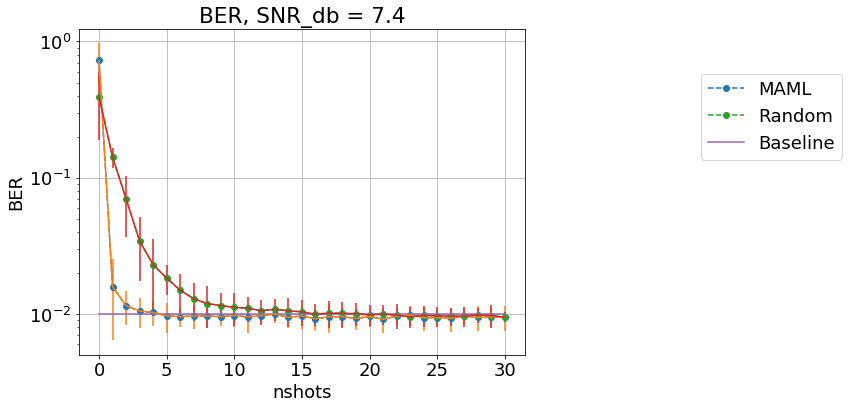

<Figure size 432x288 with 0 Axes>

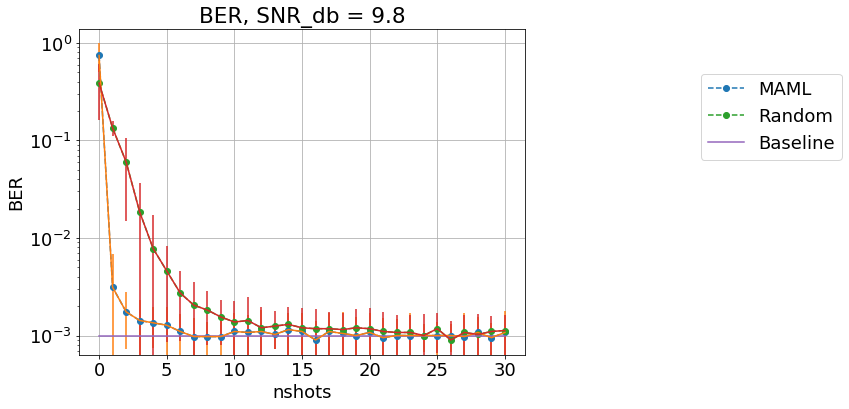

In [6]:
from utils.util_lookup_table import BER_lookup_table
from models.modulator import Modulator
from models.modulator_models.Classic import Classic as ClassicMod
from models.demodulator_models.MAMLNeural import MAMLNeural
from models.maml_demodulator import MAMLDemodulator

def test_demod(demod, mods, nshots, train_batch_size, test_batch_size, step_size, num_trials = 1, test_bers = [1e-5, 1e-2]):   
    ber_array_dict = {}
    for mod in mods:
        for trial in range(num_trials):
#         mod.update_test_old(demod, nshots=16, batch_size=32, step_size=1e-2)
            bers = demod.update_test_dev(mod, nshots=nshots, train_batch_size=train_batch_size, test_batch_size = test_batch_size, step_size=step_size, test_bers = test_bers)

            for key in bers:
                if key not in ber_array_dict:
                    ber_array_dict[key] = []
                ber_array_dict[key].append(bers[key])             
                
    for key in ber_array_dict:
        ber_array_dict[key] = np.array(ber_array_dict[key])
#         print(ber_array_dict[key].shape) 
    #Get order statistics
    return ber_array_dict

def plot_test_bers(maml_ber_array_dict, random_ber_array_dict, test_bers):
    sorted_bers = -np.sort(-np.array(test_bers))          
    for k,key in enumerate(sorted(list(maml_ber_array_dict.keys()))):      
        plt.gcf().clear()
        fig = plt.figure(figsize=(8,6))
        plt.rcParams.update({'font.size': 18})
        ax = fig.add_subplot(111)
        plt.title('BER, SNR_db = {:.1f}'.format(key))
          
        #MAML      
        ber_array_dict = maml_ber_array_dict
        ber_array = ber_array_dict[key]
        
        avg_bers = np.mean(ber_array, 0)
        median_bers = np.median(ber_array, 0)
        top_10_bers = np.percentile(ber_array,q = 90, axis = 0)
        bot_10_bers = np.percentile(ber_array,q = 10, axis = 0)       
 
        ax.plot(median_bers, 'o--', label = 'MAML')
        yerr =top_10_bers - bot_10_bers
        ax.errorbar(x = np.arange(len(median_bers)), y = median_bers, yerr = yerr)
        
        #Random
        ber_array_dict = random_ber_array_dict
        ber_array = ber_array_dict[key]
        
        avg_bers = np.mean(ber_array, 0)
        median_bers = np.median(ber_array, 0)
        top_10_bers = np.percentile(ber_array,q = 90, axis = 0)
        bot_10_bers = np.percentile(ber_array,q = 10, axis = 0)       

     
        ax.plot(median_bers, 'o--', label = 'Random')
        yerr =top_10_bers - bot_10_bers
        ax.errorbar(x = np.arange(len(median_bers)), y = median_bers, yerr = yerr)
 
        #Baseline              
        base_ber = sorted_bers[k]
        ax.plot(np.arange(len(median_bers)),base_ber*np.ones_like(median_bers), label = 'Baseline')
        
        
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(handles, labels, loc='center right', bbox_to_anchor=(1.73,0.73))
        ax.grid(True)
#         ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('nshots')
        ax.set_ylabel('BER')
        plt.show()

        
def compute_test_bers(response, query):
    ntasks = 2
    nshots = 30
    num_trials = 10
    test_batch_size = int(10000)
    test_bers = [1e-3, 1e-2]
    
    for r in range(len(response)):
        demod = create_agent_from_row(response.iloc[r], MAMLDemodulator, MAMLNeural, {'device': 'cpu'})
        print("Parameters:")
        print(response.iloc[r])
        
        bits_per_symbol = response.iloc[r]['bits_per_symbol']
        mods = [Modulator(model=ClassicMod, bits_per_symbol=bits_per_symbol, rotation=rot, verbose = True)  for rot in np.random.uniform(0, 2*np.pi, ntasks)]
        
        train_batch_size = response.iloc[r]['inner_batch_size']
        step_size = response.iloc[r]['stepsize_inner']

        maml_ber_array_dict = test_demod(test_bers = test_bers, demod=demod, mods=mods, nshots=nshots, train_batch_size=train_batch_size, test_batch_size = test_batch_size, step_size=step_size, num_trials = num_trials)
        
        # Randomize model weights
        demod.model._init_weights()
        random_ber_array_dict = test_demod(test_bers = test_bers, demod=demod, mods=mods, nshots=nshots, train_batch_size=train_batch_size, test_batch_size = test_batch_size, step_size=step_size, num_trials = num_trials)

        #TODO some filtering to get best hyperparameters
        plot_test_bers(maml_ber_array_dict, random_ber_array_dict, test_bers)

bps =2
# snr = 12
# sm = 1e-2
query = {'bits_per_symbol': bps, 'learner': 'demodulator', 'epochs': 800}#, 'SNR_db': snr, 'stepsize_meta': sm}
response = DF.search_rows(query)
print("{} results found".format(len(response)))
compute_test_bers(response, query)

1 results found
Demodulator neural initialized with SGD optimizer.
Parameters:
reduce_std_by                                    NaN
reduce_std_every                                 NaN
epochs                                           800
learner                                  demodulator
inner_batch_size                                 256
std_explore                                      NaN
restrict_energy                                  NaN
inner_steps                                       10
stepsize_meta                                    0.1
SNR_db                                            15
bits_per_symbol                                    4
optimizer                                        sgd
first_order                                    False
seed                                             777
model                                     MAMLNeural
hidden_layers                             [100, 100]
nshots                                            20
meta-alg            

<Figure size 432x288 with 0 Axes>

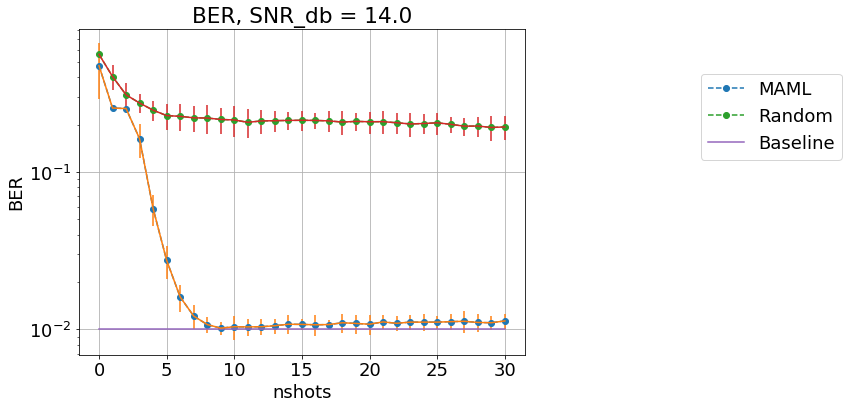

<Figure size 432x288 with 0 Axes>

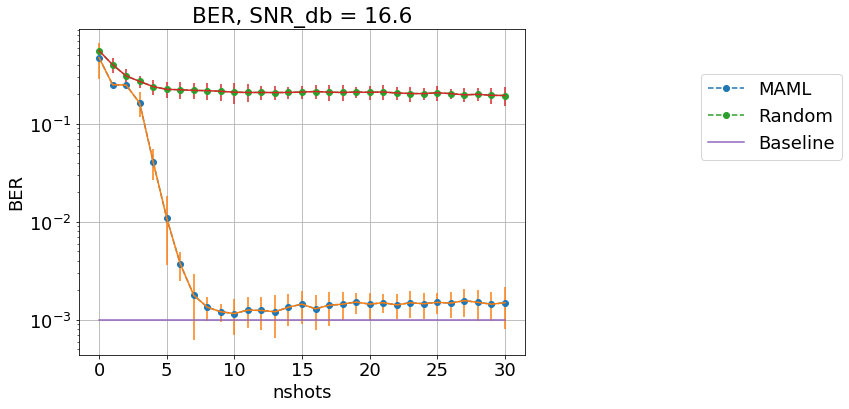

In [7]:
bps =4
# snr = 12
# sm = 1e-2
query = {'bits_per_symbol': bps, 'learner': 'demodulator', 'epochs': 800}#, 'SNR_db': snr, 'stepsize_meta': sm}
response = DF.search_rows(query)
print("{} results found".format(len(response)))
compute_test_bers(response, query)

12 results found
Demodulator neural initialized with SGD optimizer.
Parameters:
std_explore                                    None
restrict_energy                                None
inner_steps                                      10
seed                                            777
bits_per_symbol                                   2
hidden_layers                              [50, 50]
epochs                                         5000
stepsize_inner                                 0.03
first_order                                   False
model                                    MAMLNeural
SNR_db                                          8.4
ntasks                                           16
nshots                                           20
stepsize_meta                                  0.03
optimizer                                       sgd
meta-alg                                       MAML
outer_batch_size                               1024
inner_batch_size                    

<Figure size 432x288 with 0 Axes>

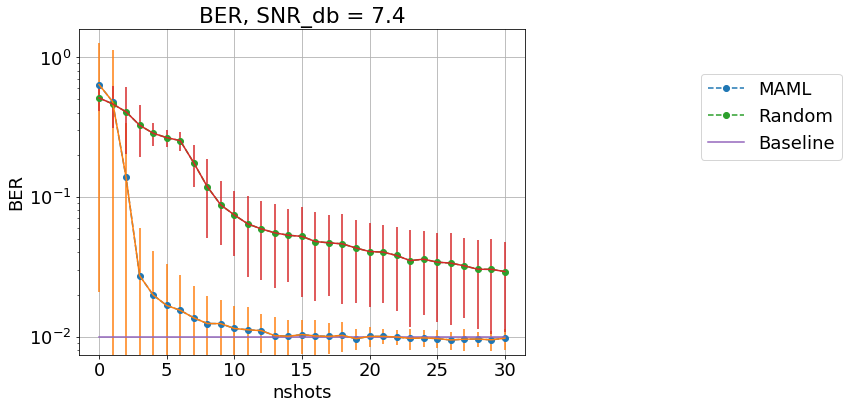

<Figure size 432x288 with 0 Axes>

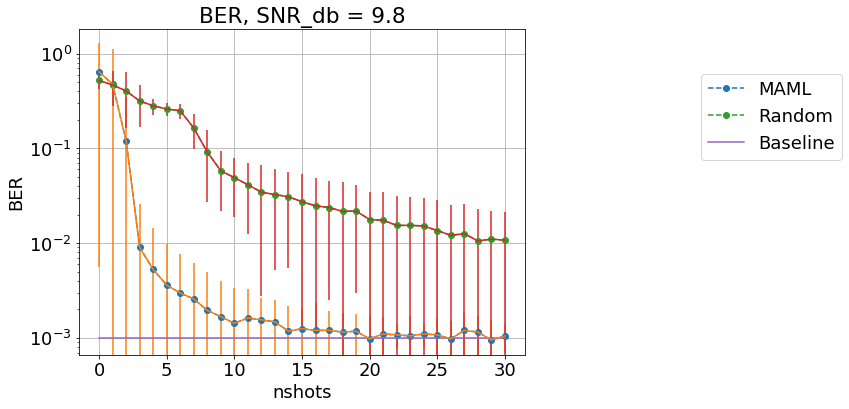

Demodulator neural initialized with SGD optimizer.
Parameters:
std_explore                                    None
restrict_energy                                None
inner_steps                                       1
seed                                            777
bits_per_symbol                                   2
hidden_layers                              [50, 50]
epochs                                         5000
stepsize_inner                                 0.03
first_order                                   False
model                                    MAMLNeural
SNR_db                                          8.4
ntasks                                           16
nshots                                           20
stepsize_meta                                   0.1
optimizer                                       sgd
meta-alg                                       MAML
outer_batch_size                               1024
inner_batch_size                                256
l

<Figure size 432x288 with 0 Axes>

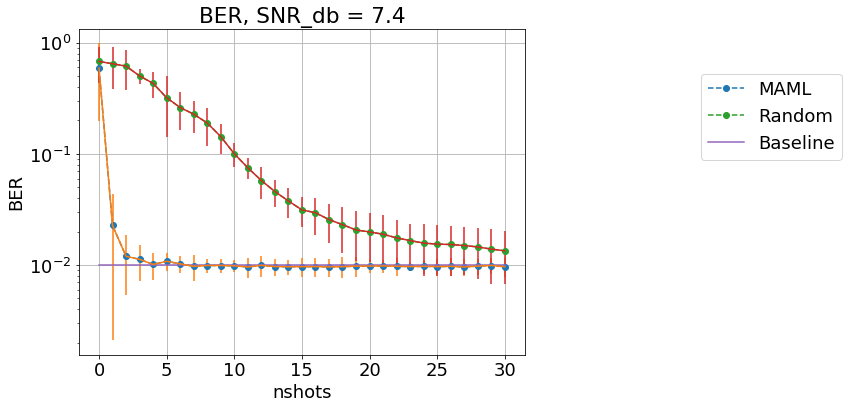

<Figure size 432x288 with 0 Axes>

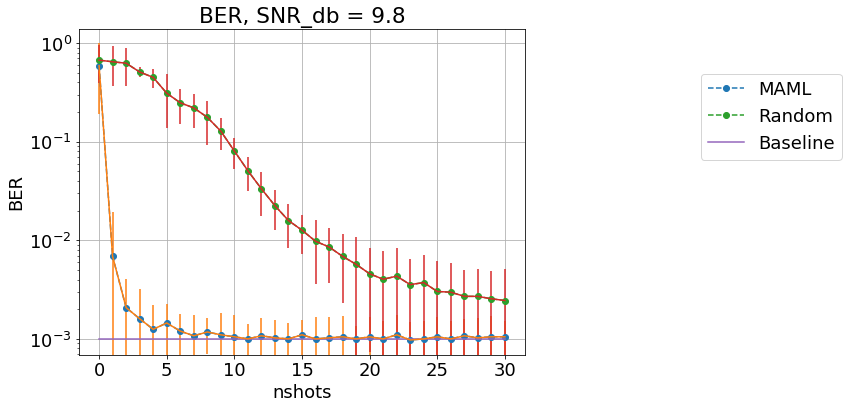

Demodulator neural initialized with SGD optimizer.
Parameters:
std_explore                                    None
restrict_energy                                None
inner_steps                                      10
seed                                            777
bits_per_symbol                                   2
hidden_layers                              [50, 50]
epochs                                         5000
stepsize_inner                                 0.03
first_order                                   False
model                                    MAMLNeural
SNR_db                                          8.4
ntasks                                           16
nshots                                           20
stepsize_meta                                   0.1
optimizer                                       sgd
meta-alg                                       MAML
outer_batch_size                               1024
inner_batch_size                                256
l

<Figure size 432x288 with 0 Axes>

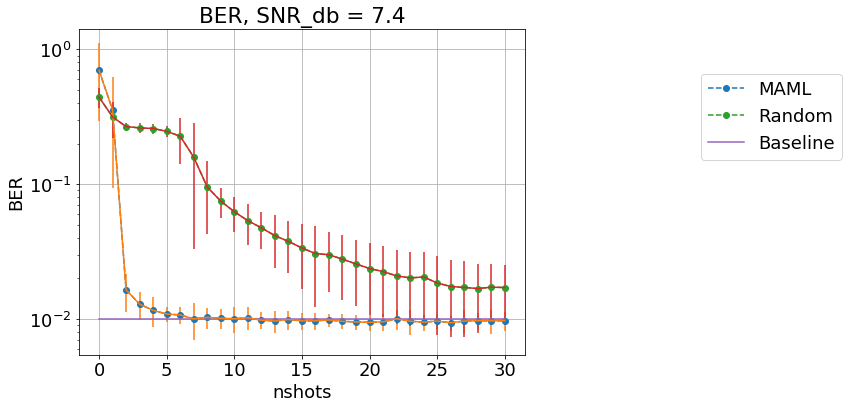

<Figure size 432x288 with 0 Axes>

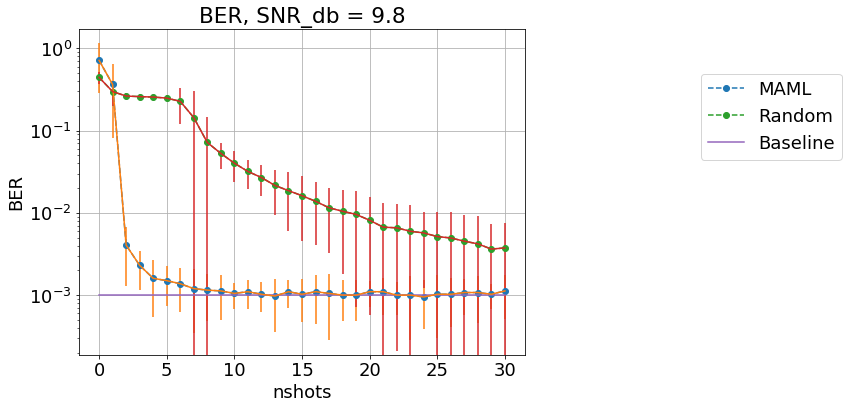

Demodulator neural initialized with SGD optimizer.
Parameters:
std_explore                                     None
restrict_energy                                 None
inner_steps                                        1
seed                                             777
bits_per_symbol                                    2
hidden_layers                               [50, 50]
epochs                                          5000
stepsize_inner                                  0.03
first_order                                    False
model                                     MAMLNeural
SNR_db                                           8.4
ntasks                                            16
nshots                                            20
stepsize_meta                                    0.2
optimizer                                        sgd
meta-alg                                        MAML
outer_batch_size                                1024
inner_batch_size                    

<Figure size 432x288 with 0 Axes>

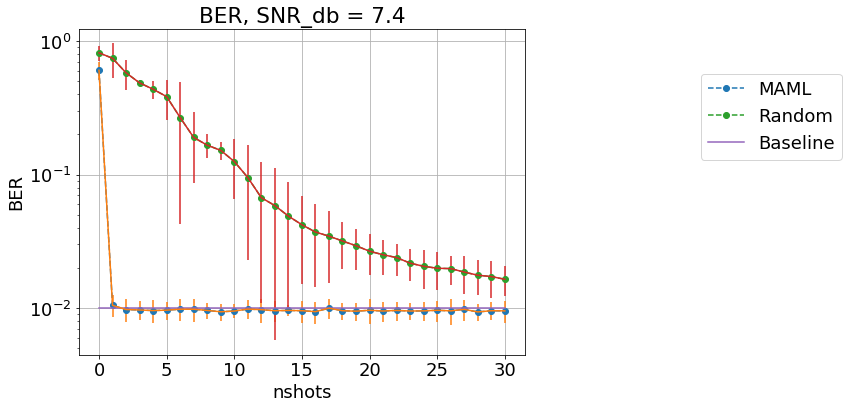

<Figure size 432x288 with 0 Axes>

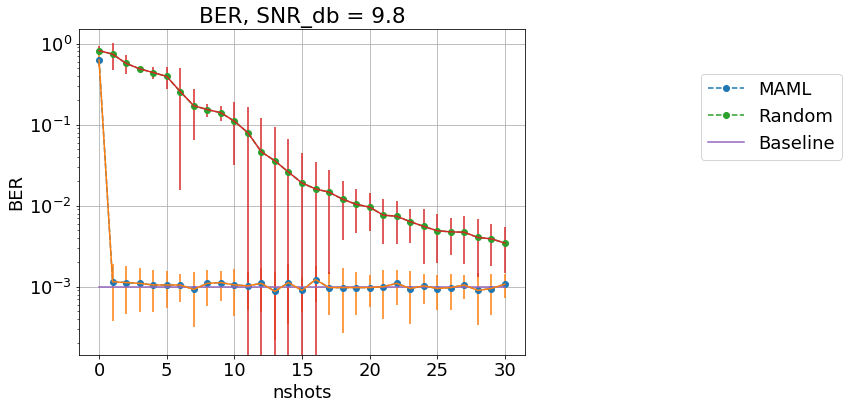

Demodulator neural initialized with SGD optimizer.
Parameters:
std_explore                                     None
restrict_energy                                 None
inner_steps                                       10
seed                                             777
bits_per_symbol                                    2
hidden_layers                               [50, 50]
epochs                                          5000
stepsize_inner                                  0.03
first_order                                     True
model                                     MAMLNeural
SNR_db                                           8.4
ntasks                                            16
nshots                                            20
stepsize_meta                                    0.2
optimizer                                        sgd
meta-alg                                        MAML
outer_batch_size                                1024
inner_batch_size                    

<Figure size 432x288 with 0 Axes>

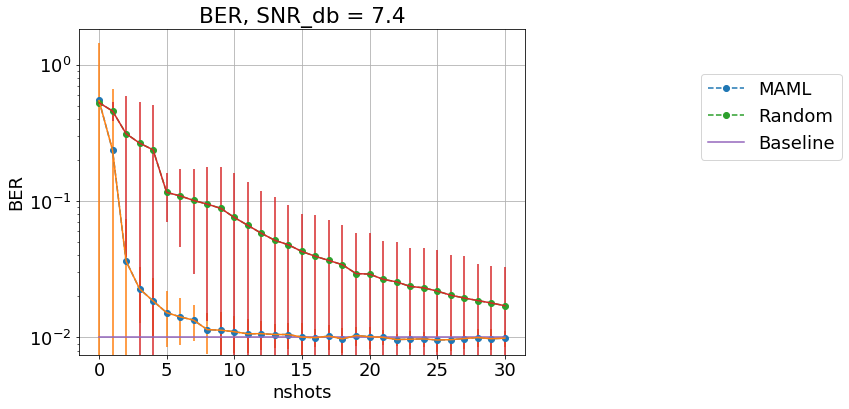

<Figure size 432x288 with 0 Axes>

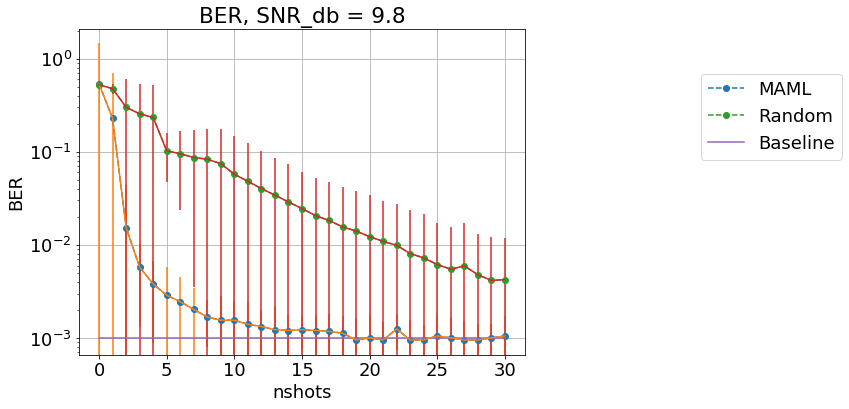

Demodulator neural initialized with SGD optimizer.
Parameters:
std_explore                                     None
restrict_energy                                 None
inner_steps                                       10
seed                                             777
bits_per_symbol                                    2
hidden_layers                               [50, 50]
epochs                                          5000
stepsize_inner                                   0.2
first_order                                    False
model                                     MAMLNeural
SNR_db                                           8.4
ntasks                                            16
nshots                                            20
stepsize_meta                                    0.2
optimizer                                        sgd
meta-alg                                        MAML
outer_batch_size                                1024
inner_batch_size                    

<Figure size 432x288 with 0 Axes>

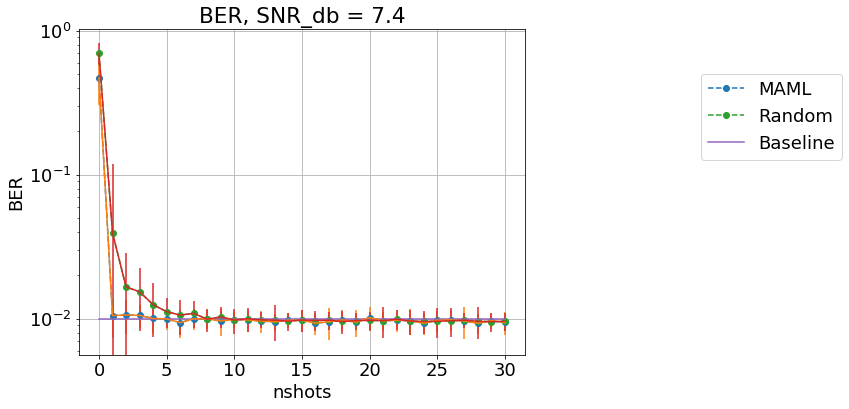

<Figure size 432x288 with 0 Axes>

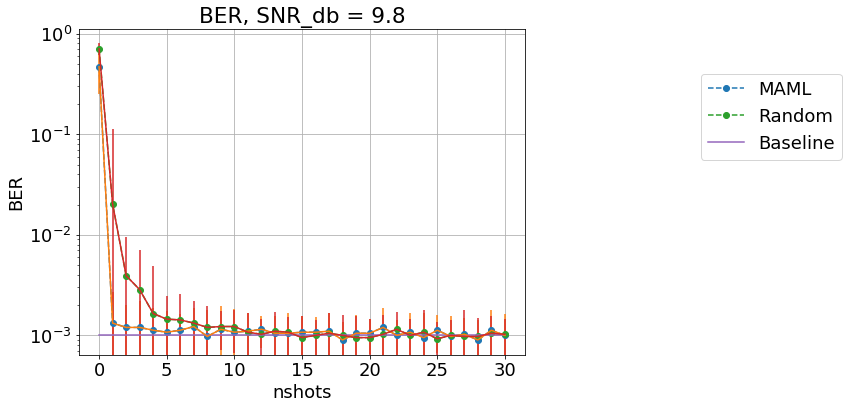

Demodulator neural initialized with SGD optimizer.
Parameters:
std_explore                                      NaN
restrict_energy                                  NaN
inner_steps                                        1
seed                                             777
bits_per_symbol                                    2
hidden_layers                               [50, 50]
epochs                                          5000
stepsize_inner                                   0.1
first_order                                    False
model                                     MAMLNeural
SNR_db                                           8.4
ntasks                                            16
nshots                                            20
stepsize_meta                                   0.03
optimizer                                        sgd
meta-alg                                        MAML
outer_batch_size                                1024
inner_batch_size                    

<Figure size 432x288 with 0 Axes>

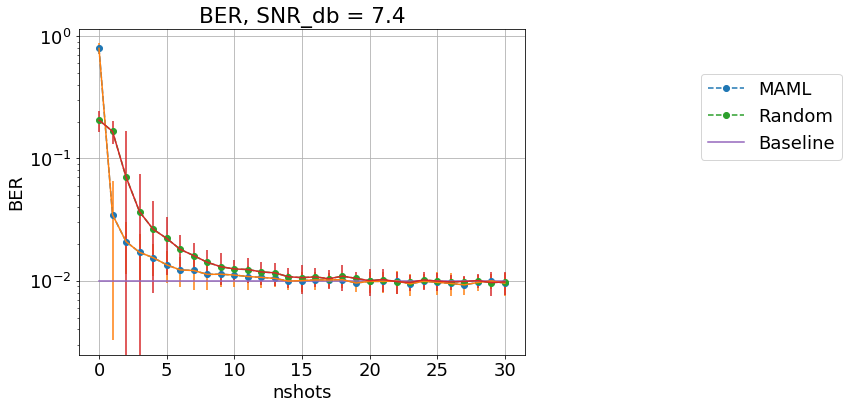

<Figure size 432x288 with 0 Axes>

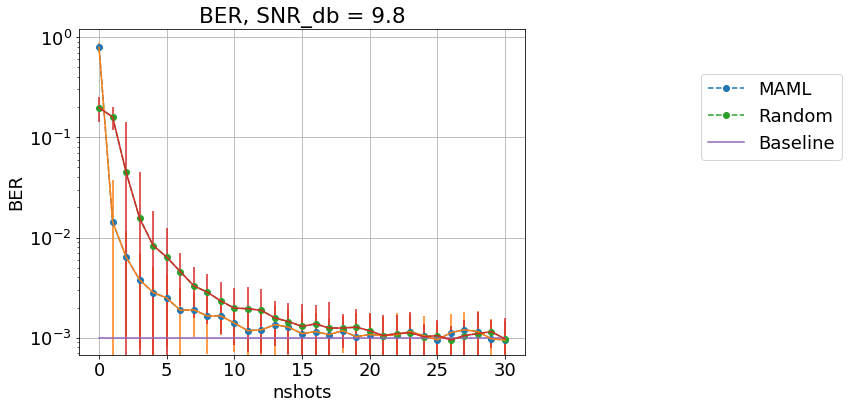

Demodulator neural initialized with SGD optimizer.
Parameters:
std_explore                                      NaN
restrict_energy                                  NaN
inner_steps                                       10
seed                                             777
bits_per_symbol                                    2
hidden_layers                               [50, 50]
epochs                                          5000
stepsize_inner                                   0.1
first_order                                    False
model                                     MAMLNeural
SNR_db                                           8.4
ntasks                                            16
nshots                                            20
stepsize_meta                                   0.03
optimizer                                        sgd
meta-alg                                        MAML
outer_batch_size                                1024
inner_batch_size                    

<Figure size 432x288 with 0 Axes>

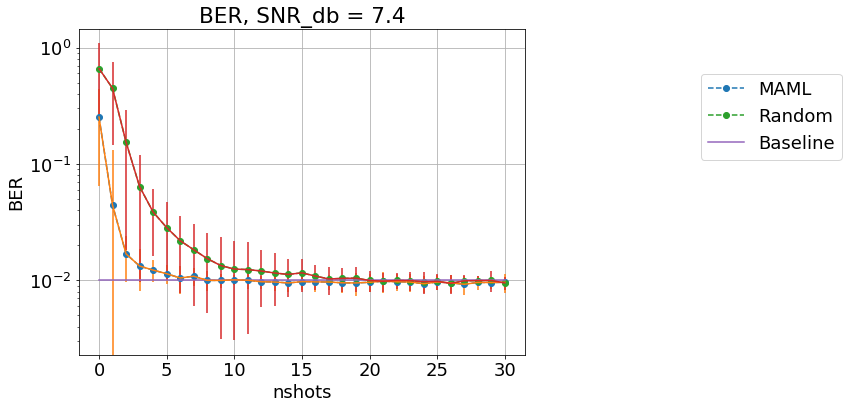

<Figure size 432x288 with 0 Axes>

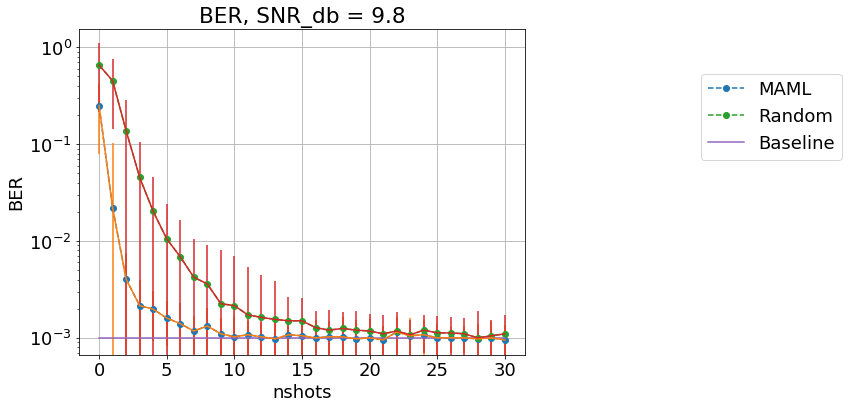

Demodulator neural initialized with SGD optimizer.
Parameters:
std_explore                                      NaN
restrict_energy                                  NaN
inner_steps                                        5
seed                                             777
bits_per_symbol                                    2
hidden_layers                               [50, 50]
epochs                                          5000
stepsize_inner                                   0.1
first_order                                     True
model                                     MAMLNeural
SNR_db                                           8.4
ntasks                                            16
nshots                                            20
stepsize_meta                                    0.1
optimizer                                        sgd
meta-alg                                        MAML
outer_batch_size                                1024
inner_batch_size                    

<Figure size 432x288 with 0 Axes>

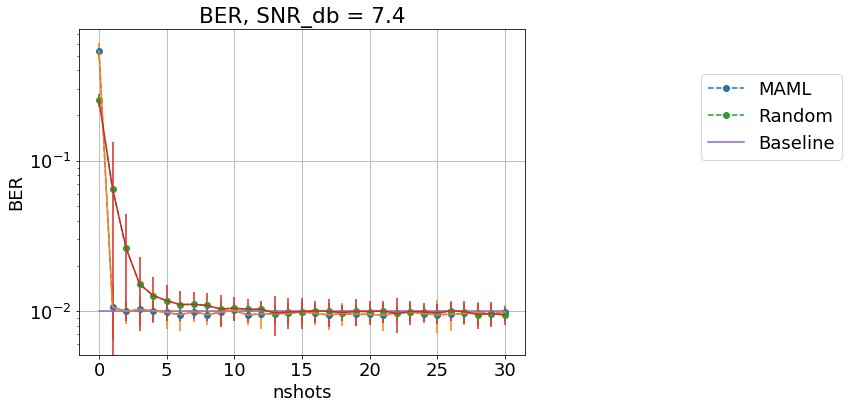

<Figure size 432x288 with 0 Axes>

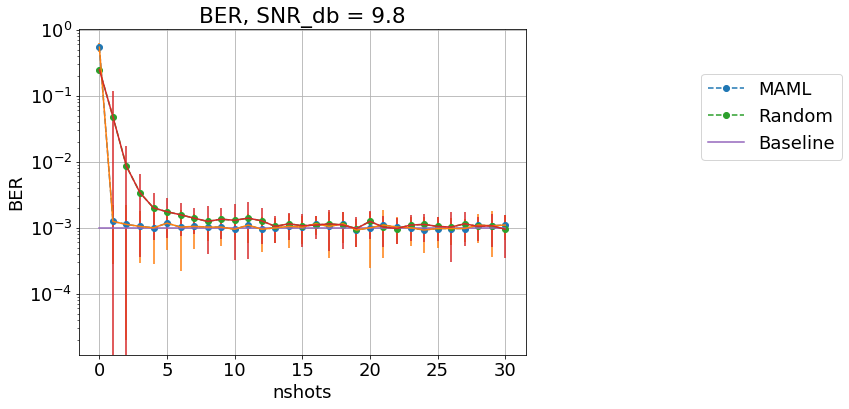

Demodulator neural initialized with SGD optimizer.
Parameters:
std_explore                                      NaN
restrict_energy                                  NaN
inner_steps                                       10
seed                                             777
bits_per_symbol                                    2
hidden_layers                               [50, 50]
epochs                                          5000
stepsize_inner                                   0.2
first_order                                     True
model                                     MAMLNeural
SNR_db                                           8.4
ntasks                                            16
nshots                                            20
stepsize_meta                                    0.1
optimizer                                        sgd
meta-alg                                        MAML
outer_batch_size                                1024
inner_batch_size                    

<Figure size 432x288 with 0 Axes>

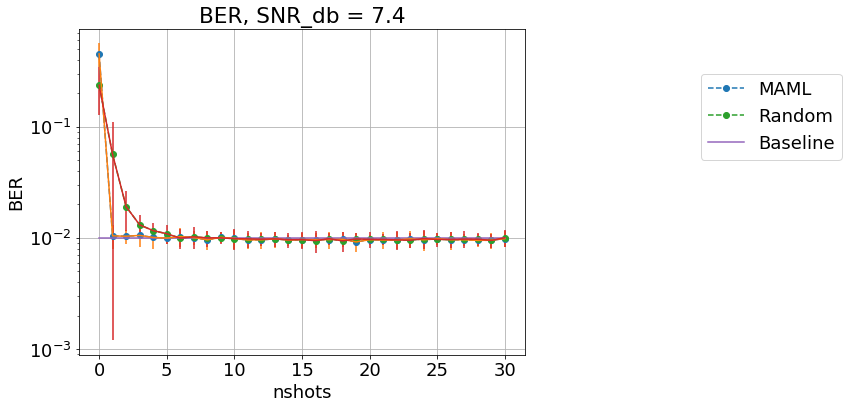

<Figure size 432x288 with 0 Axes>

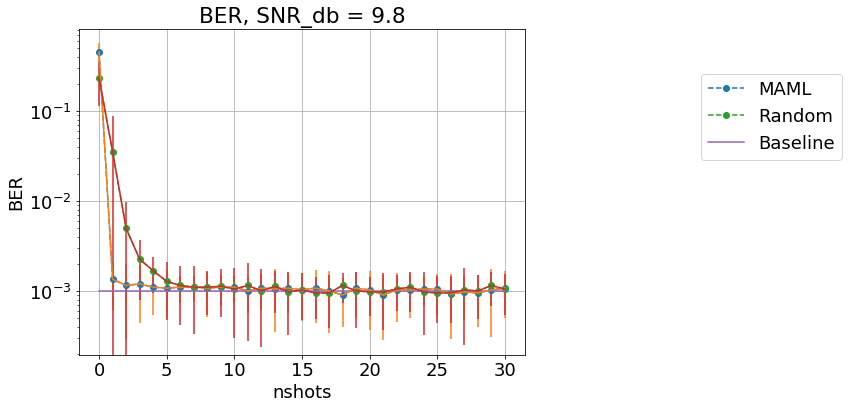

Demodulator neural initialized with SGD optimizer.
Parameters:
std_explore                                      NaN
restrict_energy                                  NaN
inner_steps                                        1
seed                                             777
bits_per_symbol                                    2
hidden_layers                               [50, 50]
epochs                                          5000
stepsize_inner                                   0.2
first_order                                    False
model                                     MAMLNeural
SNR_db                                           8.4
ntasks                                            16
nshots                                            20
stepsize_meta                                    0.2
optimizer                                        sgd
meta-alg                                        MAML
outer_batch_size                                1024
inner_batch_size                    

<Figure size 432x288 with 0 Axes>

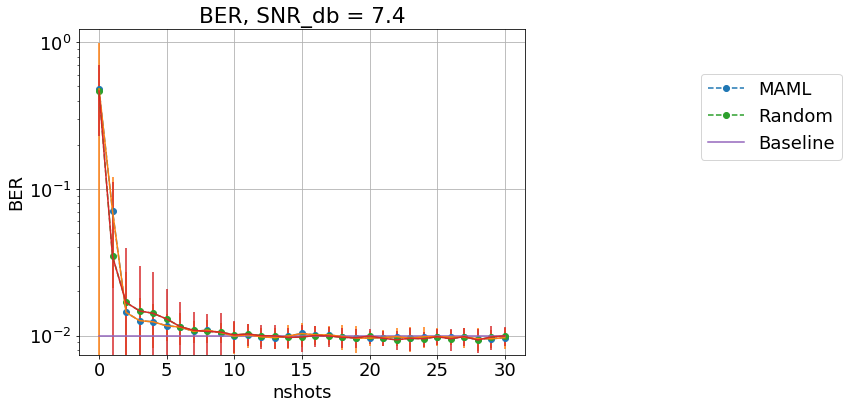

<Figure size 432x288 with 0 Axes>

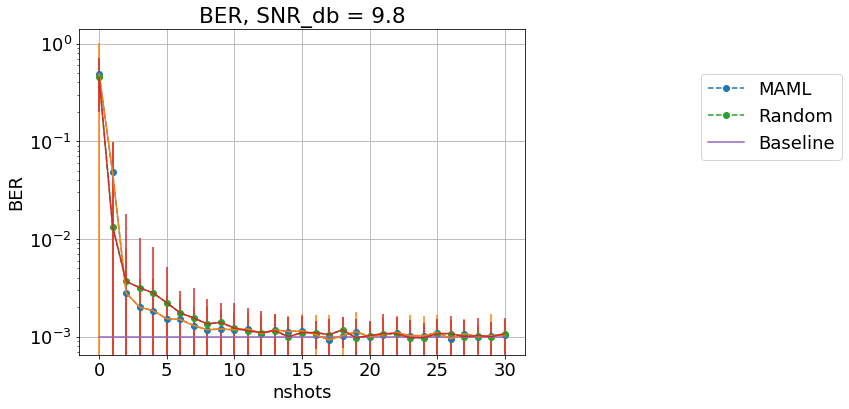

Demodulator neural initialized with SGD optimizer.
Parameters:
std_explore                                      NaN
restrict_energy                                  NaN
inner_steps                                       10
seed                                             777
bits_per_symbol                                    2
hidden_layers                               [50, 50]
epochs                                          5000
stepsize_inner                                   0.2
first_order                                     True
model                                     MAMLNeural
SNR_db                                           8.4
ntasks                                            16
nshots                                            20
stepsize_meta                                    0.2
optimizer                                        sgd
meta-alg                                        MAML
outer_batch_size                                1024
inner_batch_size                    

<Figure size 432x288 with 0 Axes>

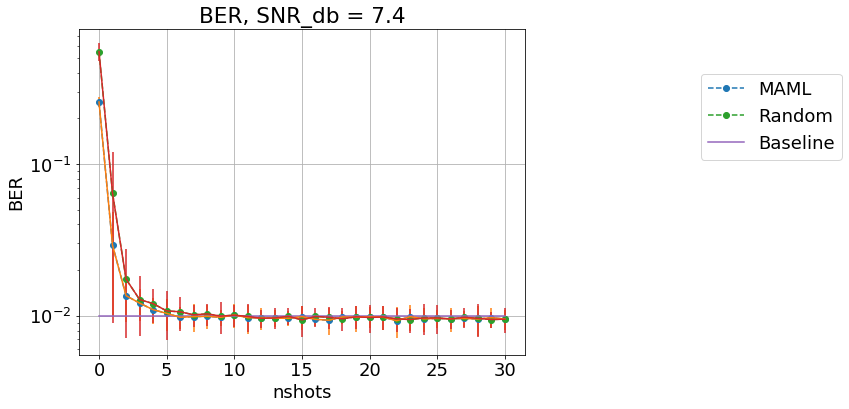

<Figure size 432x288 with 0 Axes>

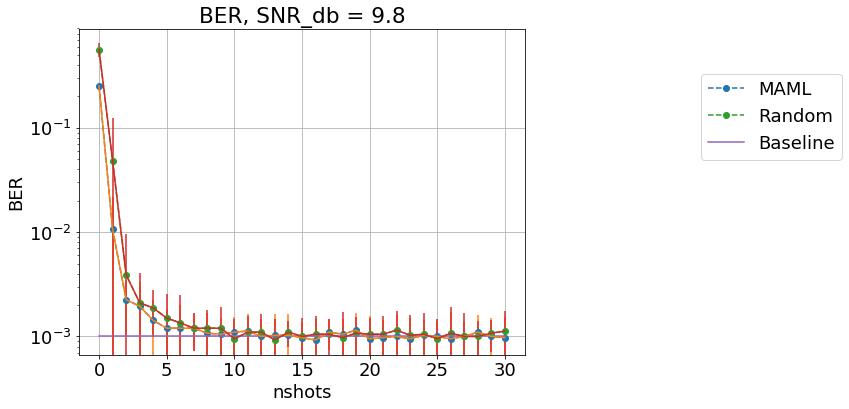

In [8]:
bps =6
# snr = 12
# sm = 1e-2
query = {'bits_per_symbol': bps, 'learner': 'demodulator'}#, 'SNR_db': snr, 'stepsize_meta': sm}
response = DF.search_rows(query)
print("{} results found".format(len(response)))
compute_test_bers(response, query)